In [61]:
import pandas as pd
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Batter Segmentation Analysis

In [62]:
batter_data = pd.read_csv('C:/Users/wanns/OneDrive/Desktop/Coding/MSDS/DS6021-Project/data/cleaned/final_batters_df.csv')

In [63]:
batter_data.head()

,row_id,playerID,year,position,age,avg_salary_year,free_agent_salary,contract_length,AB,R,...,E,DP,PB,WP,ZR,won_cy_young,won_mvp,won_gold_glove,won_silver_slugger,all_star
0,baergca01_2003,baergca01,2003,2B,35,2.573473e+06,1000000.0,1.0,389,48,...,4.0,27.0,0.0,0.0,NaN,0,0,0,0,0
1,barajro01_2003,barajro01,2003,C,28,2.573473e+06,500000.0,1.0,480,40,...,2.0,10.0,12.0,0.0,NaN,0,0,0,0,0
2,belliro01_2003,belliro01,2003,2B,28,2.573473e+06,1100000.0,1.0,1100,172,...,30.0,177.0,0.0,0.0,NaN,0,0,0,0,0
3,blanche01_2003,blanche01,2003,C,32,2.573473e+06,750000.0,1.0,686,61,...,10.0,14.0,13.0,0.0,NaN,0,0,0,0,0
4,butlebr02_2003,butlebr02,2003,2B,25,2.573473e+06,NaN,1.0,553,85,...,17.0,81.0,0.0,0.0,NaN,0,0,0,0,0


In [64]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

In [65]:
# decide what features to use for clustering (initially remove categorical features where distance metrics don't make sense)
X = batter_data.select_dtypes(include=['float64', 'int64'])
X.dtypes

year                    int64
age                     int64
avg_salary_year       float64
free_agent_salary     float64
contract_length       float64
AB                      int64
R                       int64
H                       int64
2B                      int64
3B                      int64
HR                      int64
RBI                     int64
SB                      int64
CS                      int64
BB                      int64
SO                      int64
IBB                     int64
HBP                     int64
SH                      int64
SF                      int64
GIDP                    int64
InnOuts               float64
PO                    float64
A                     float64
E                     float64
DP                    float64
PB                    float64
WP                    float64
ZR                    float64
won_cy_young            int64
won_mvp                 int64
won_gold_glove          int64
won_silver_slugger      int64
all_star  

In [66]:
# remove variables where distance isn't meaningful like year and salary since we want to look at performance for batters (offense stats only)
X = X.drop(columns=['year', 'free_agent_salary', 'PB', 'WP', 'won_cy_young', 'won_mvp', 'won_gold_glove', 'won_silver_slugger', 'all_star', 'PO', 'InnOuts', 'A', 'E', 'ZR'])
X.columns


Index(['age', 'avg_salary_year', 'contract_length', 'AB', 'R', 'H', '2B', '3B',
       'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP',
       'DP'],
      dtype='object')

In [67]:
# 1. Total Plate Appearances (The denominator for rates)
X['PA'] = X['AB'] + X['BB'] + X['HBP'] + X['SF'] + X['SH']

# 2. Slugging Percentage (SLG)
X['SLG'] = ((X['H'] - X['2B'] - X['3B'] - X['HR']) + 
            (2 * X['2B']) + (3 * X['3B']) + (4 * X['HR'])) / X['AB']

# 3. Plate Discipline Metrics 
X['BB_rate'] = X['BB'] / X['PA']   # Walk rate: Measures patience
X['SO_rate'] = X['SO'] / X['PA']   # Strikeout rate: Measures contact ability

# 4. Luck/Fielding Metric (BABIP)
# Measures hit rate on balls in play (excludes HR and SO)
X['BABIP'] = (X['H'] - X['HR']) / (X['AB'] - X['SO'] - X['HR'] + X['SF'])

# 5. Baserunning Efficiency
# Success rate of stealing bases (handling divide by zero if no attempts)
X['SB_EFF'] = X['SB'] / (X['SB'] + X['CS'])
X['SB_EFF'] = X['SB_EFF'].fillna(0) # Fill players with 0 steal attempts

# 6. Drop original count columns
X.drop(columns=['AB', 'PA', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS',
                'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'DP'], inplace=True)


We dropped raw counting stats that are heavily affected by playing time, aka PA, and replaced them with rate-based metrics based on plate appearances, so we are comparing stats based on assumption that they have the same number of opportunities to make a play. The variables we have now are:

age - same as before
AVG - batting average, how often hitter gets a base hit
OBP - on base percentage, how often hitter reaches base by any means
SLG - slugging percentage,  how many bases gained per at-bat
ISO - how much of player's production comes from extra base hits like doubles, triples, home runs
contract_length - how long the contract is

### Missing Values

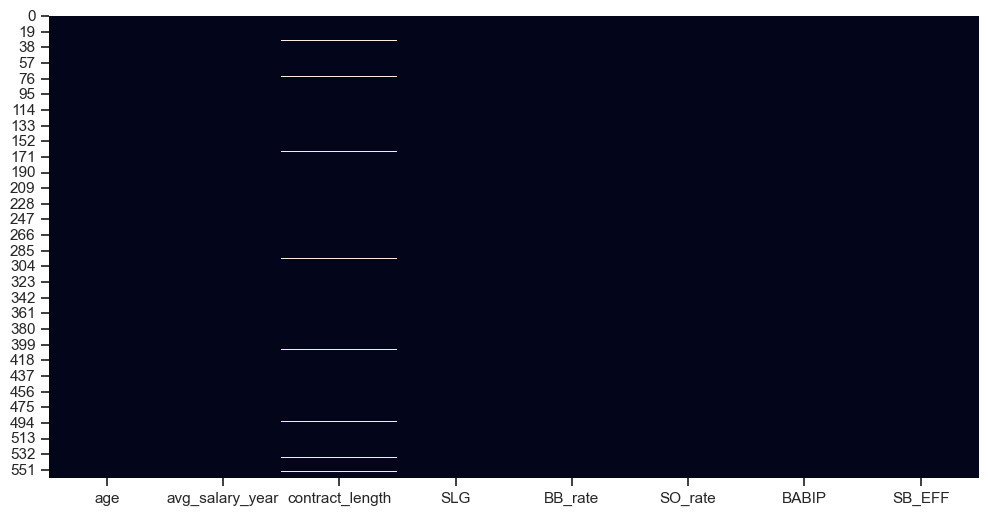

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(X.isnull(), cbar=False)
plt.show()

Barely any data is missing so we are safe to drop na.

In [69]:
X = X.dropna()
Xorig = X.copy()
X = X.drop(columns=['avg_salary_year', 'contract_length'])

In [70]:
K_values = list(range(1, 11))
wcss = []

for k in K_values:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)
    inertia = pipe["kmeans"].inertia_
    wcss.append(inertia)


fig = px.line(
    x=K_values,
    y=wcss,
    markers=True,
    title="Elbow Plot (Pipeline: StandardScaler + KMeans)",
    labels={"x": "Number of Clusters (K)", "y": "WCSS / Inertia"}
)

fig.update_layout(height=500, width=700)
fig.show()

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Wi

k = 4 looks to be optimal based on elbow, look at sihouette score next

In [71]:
sil_scores = []
K_values_sil = list(range(2, 11))

for k in K_values_sil:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)

    labels = pipe["kmeans"].labels_

    sil = silhouette_score(X, labels)

    sil_scores.append(sil)


fig = px.line(
    x=K_values_sil,
    y=sil_scores,
    markers=True,
    title="Silhouette Scores (Pipeline: StandardScaler + KMeans)",
    labels={"x": "Number of Clusters (K)", "y": "Silhouette Score"}
)

fig.update_layout(height=500, width=700)
fig.show()


c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Wi

Looks like 2 clusters is best

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



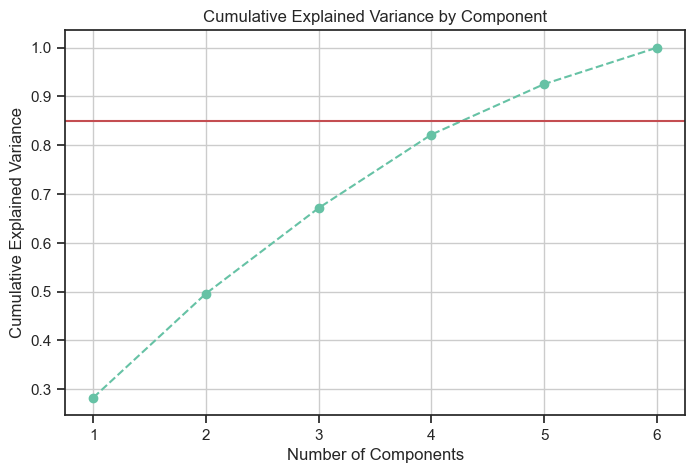

In [72]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

# 2. Fit PCA with all possible components (6)
pipe.fit(X)
pca = pipe["pca"]

# 3. Plot the Cumulative Explained Variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, 7), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='-') # Threshold line at 90%
plt.grid()
plt.show()

In [73]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

pipe.fit(X)
labels = pipe["kmeans"].labels_

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



### Principal Direction Contributions

PC1 is a perfomance based axis for power and onbase ability (higher PC1 is better hitter), PC2 is essentially just age (higher PC2 is older), PC3 is a AVG vs SLG contrast (higher PC3 is better SLG but worse AVG stats).

In [74]:
pca_loadings = pd.DataFrame(
    pipe["pca"].components_.T, 
    index=X.columns, 
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
)
pca_loadings


,PC1,PC2,PC3,PC4,PC5
age,0.078854,-0.347722,0.773056,0.396339,0.254944
SLG,0.596241,-0.190279,0.003102,-0.274056,-0.504639
BB_rate,0.562577,0.266220,0.122893,0.407273,-0.278444
SO_rate,0.388852,0.597319,-0.091616,0.033566,0.593254
BABIP,0.404470,-0.516697,-0.113119,-0.408175,0.493687
SB_EFF,0.083574,-0.385024,-0.605047,0.658941,0.084464


### Principal Component Scores

In [75]:
X_pca = pipe[:-1].transform(X) # Exclude the KMeans step to get PCA-transformed data
pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=X.index)

,PC1,PC2,PC3,PC4,PC5
0,-0.082194,-2.583267,-0.258783,-0.151137,0.386168
1,-2.153284,0.967322,-1.901266,1.249503,-0.132161
2,-0.536053,0.282073,-1.134491,-0.225272,-0.541255
3,-1.627212,1.681391,0.312132,0.887140,-0.256729
4,-2.431032,0.754135,-1.091943,-1.496389,-1.368956
...,...,...,...,...,...
556,0.360663,-0.603973,0.348807,0.605023,-0.601733
557,0.421774,0.115615,-0.789465,-1.086704,0.012940
558,2.956132,1.449613,-0.964644,-0.609018,-0.077079
559,1.965758,0.621037,-1.598265,-0.368653,0.339508


### PC Contribution to Variance Explanation

In [76]:
eigenvalues = pipe["pca"].explained_variance_
variance_ratios = pipe["pca"].explained_variance_ratio_
cumulative_variance = variance_ratios.cumsum()

import pandas as pd

pd.DataFrame({
    'Eigenvalue': eigenvalues,
    'Variance Proportion': variance_ratios,
    'Cumulative Variance': cumulative_variance
}, index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])


,Eigenvalue,Variance Proportion,Cumulative Variance
PC1,1.699552,0.282743,0.282743
PC2,1.282689,0.213392,0.496135
PC3,1.053855,0.175323,0.671457
PC4,0.904684,0.150506,0.821963
PC5,0.621604,0.103412,0.925375


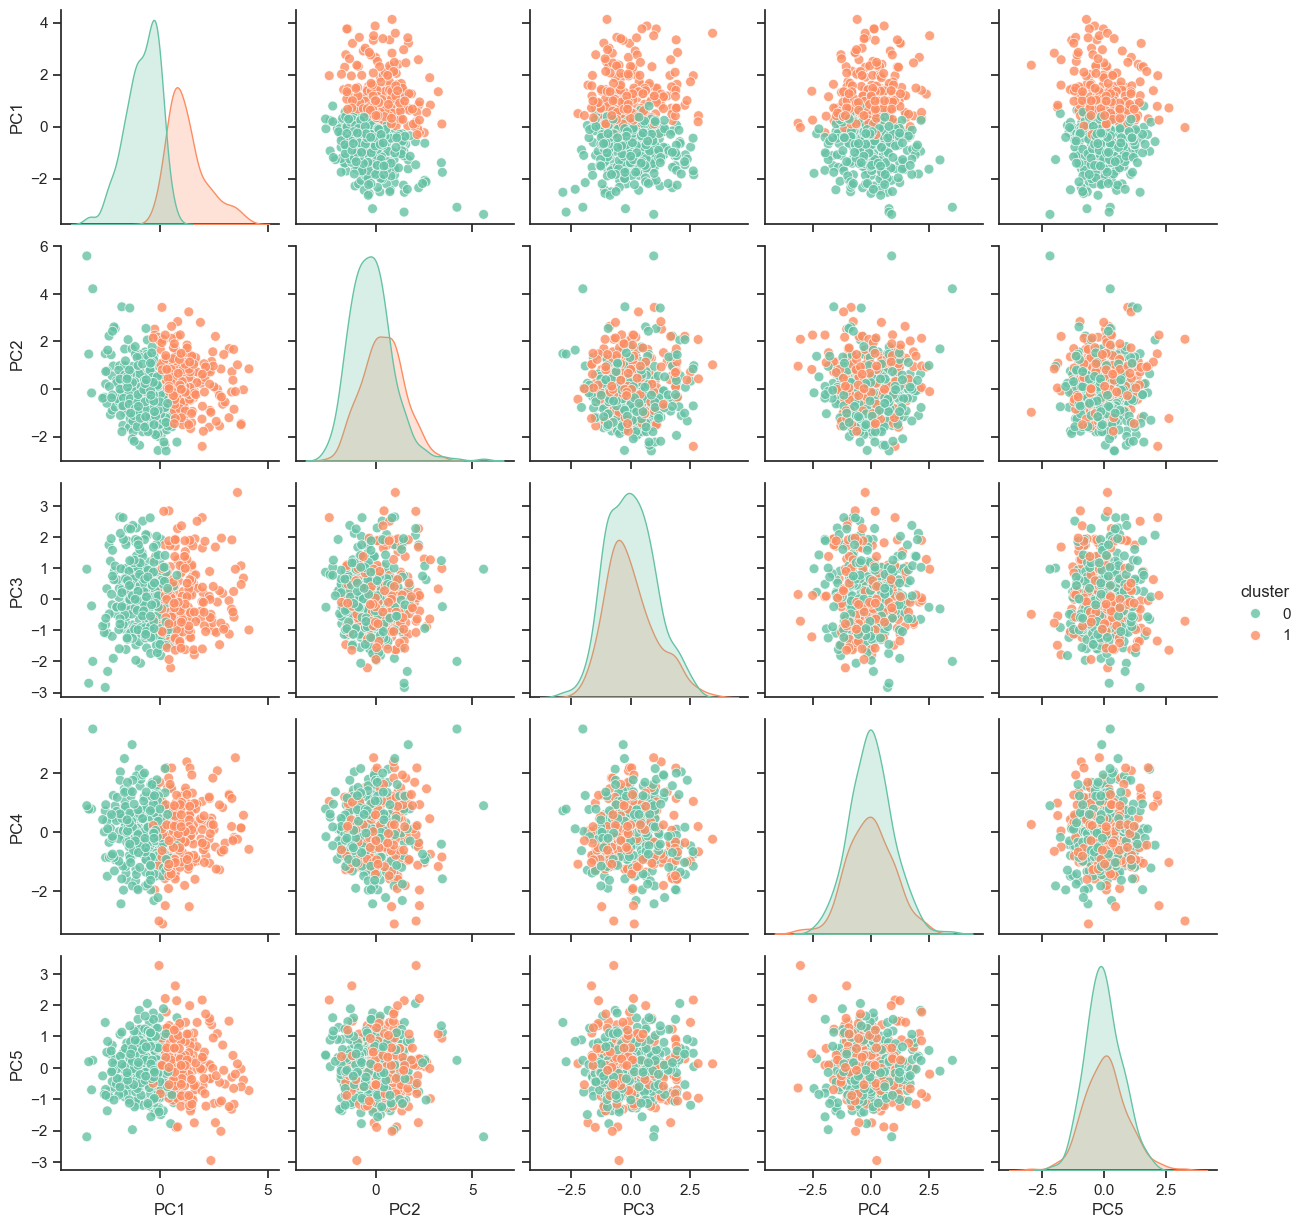

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

X_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
X_plot['cluster'] = labels.astype(str)

sns.set(style="ticks")
pair_plot = sns.pairplot(
    X_plot, 
    hue='cluster', 
    palette='Set2', 
    diag_kind='kde',
    plot_kws={'alpha': 0.8, 's': 50})

plt.show()

Best separation we can see if PC1 x PC any other PC pair

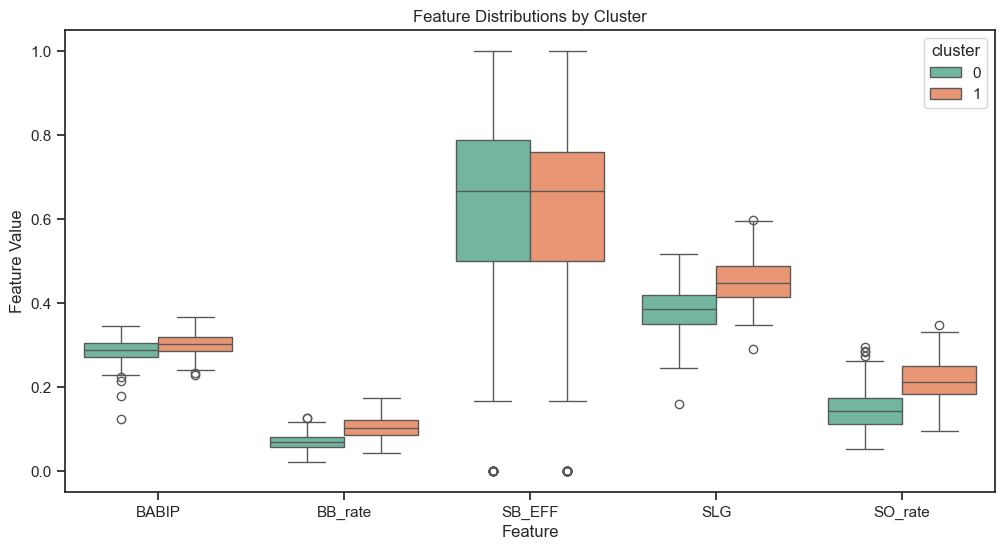

In [79]:
X['cluster'] = labels.astype(str)
plot_df = X.melt(id_vars='cluster', value_vars=X.columns.difference(['cluster', 'age']), var_name='Feature', value_name='Value')
plt.figure(figsize=(12,6))
sns.boxplot(x='Feature', y='Value', hue='cluster', data=plot_df, palette='Set2')
plt.title("Feature Distributions by Cluster")
plt.ylabel("Feature Value")
plt.xlabel("Feature")
plt.show()

What separates a good from a bad player in these clusters seems to have more emphasis on SLG and ISO, aka power stats, than plate related stats, but they all seem to contribute important information to distinguish between the clusters.

### Salary and Contract Length Comparisons Across Clusters

In [80]:
Xorig['cluster'] = labels.astype(str)
Xorig.groupby('cluster')[['avg_salary_year', 'contract_length']].agg(['mean','median','std', 'count'])

avg_salary_year                                    contract_length  \
                   mean        median            std count            mean   
cluster                                                                      
0          3.138097e+06  3.136517e+06  498985.895750   333        1.489489   
1          3.237910e+06  3.277647e+06  541081.569091   216        1.875000   

                                
        median       std count  
cluster                         
0          1.0  0.949339   333  
1          1.0  1.754231   216

In [81]:
fig_salary = px.box(
    Xorig, 
    x='cluster', 
    y='avg_salary_year', 
    color='cluster',
    title="Average Yearly Salary by Batter Cluster",
    labels={'avg_salary_year': 'Avg Salary per Year ($)', 'cluster': 'Batter Segment'},
)
fig_salary.show()

fig_len = px.box(
    Xorig, 
    x='cluster', 
    y='contract_length', 
    color='cluster',
    title="Contract Length by Batter Cluster",
    labels={'contract_length': 'Years of Contract', 'cluster': 'Batter Segment'},
)
fig_len.show()

### Is this significant difference?

In [82]:
from scipy import stats

cluster_0_salary = Xorig[Xorig['cluster'] == '0']['avg_salary_year']
cluster_1_salary = Xorig[Xorig['cluster'] == '1']['avg_salary_year']

t_stat, p_val = stats.ttest_ind(cluster_0_salary, cluster_1_salary, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("Result: Significant. The market values these player segments differently.")
else:
    print("Result: Not significant. The clusters do not represent a meaningful pay difference.")

cluster_0_contract = Xorig[Xorig['cluster'] == '0']['contract_length']
cluster_1_contract = Xorig[Xorig['cluster'] == '1']['contract_length']

t_stat, p_val = stats.ttest_ind(cluster_0_contract, cluster_1_contract, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("Result: Significant. The market contracts these player segments differently.")
else:
    print("Result: Not significant. The clusters do not represent a meaningful contract length difference.")

T-statistic: -2.1765
P-value: 3.0060e-02
Result: Significant. The market values these player segments differently.
T-statistic: -2.9608
P-value: 3.3155e-03
Result: Significant. The market contracts these player segments differently.


### Handling baseball contracts usually being 1 year, want to see actual difference not just significant or not

In [83]:
import numpy as np

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

d = cohens_d(cluster_0_contract, cluster_1_contract)
print(f"Cohen's d: {d:.4f}")

Cohen's d: -0.2909


Relatively negligable gap in contract length, is probably only significant because of high sample size and cluster 1 having a few outliers skewing the mean.